In [3]:
import torch.nn.functional as F
from torch.utils import data
import torch
import os
import random
import numpy as np


number=3
sample=2**(number+2)
cl=16
indice1 = 300

train = np.load("train.npy")
train = torch.from_numpy(np.stack(train, 0))
test = np.load("test.npy")
test = torch.from_numpy(np.stack(test, 0))
valid = np.load("valid.npy")
valid = torch.from_numpy(np.stack(valid, 0))

print(train.shape)
print(test.shape)
print(valid.shape)

label=np.arange(0,cl,1)
label = label.astype(np.float32)
train_label = torch.from_numpy(np.tile(label, indice1)) 
test_label  = torch.from_numpy(np.tile(label, 100))
valid_label = torch.from_numpy(np.tile(label, 2))

print(train_label.dtype)
print(train_label.shape)
print(test_label.shape)
print(valid_label.shape)


from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

train_dataset = TensorDataset(train, train_label)
valid_dataset = TensorDataset(valid, valid_label)
test_dataset = TensorDataset(test, test_label)
batch=cl*2

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch,            
    shuffle= True,          
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch,           
    shuffle= True,          
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch,     
    shuffle= True,            
)

torch.Size([4800, 32, 204])
torch.Size([1600, 32, 204])
torch.Size([32, 32, 204])
torch.float32
torch.Size([4800])
torch.Size([1600])
torch.Size([32])


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse

from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
import os
import random


parser = argparse.ArgumentParser(description='Sequence Modeling')
parser.add_argument('--batch_size', type=int, default=batch, metavar='N',
                    help='batch size (default: 128)')
parser.add_argument('--cuda', action='store_true', default=False,
                    help='Disable cuda for training')
parser.add_argument('--dropout', type=float, default=0.45,
                    help='dropout applied to layers (default: 0.05)')
parser.add_argument('--clip', type=float, default=0.35,
                    help='gradient clip, -1 means no clip (default: -1)')
parser.add_argument('--epochs', type=int, default=30,
                    help='upper epoch limit (default: 20)')
parser.add_argument('--levels', type=int, default=4,
                    help='# of levels (default: 8)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='report interval (default: 100')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate (default: 2e-3)')
parser.add_argument('--optim', type=str, default='Adam',
                    help='optimizer to use (default: Adam)')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed (default: 1111)')
parser.add_argument('--seq_len', type=int, default=204)

args = parser.parse_args([])

if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
print(args)

torch.manual_seed(args.seed)
batch_size = args.batch_size 
print('batch_size:',batch_size)
epochs = args.epochs  
input_channels = sample
print('input_channels:',input_channels)
channel_sizes = [input_channels*2] * args.levels 
n_classes = cl
print('n_classes:',n_classes)
steps = 0


import math
from einops import rearrange
from torch.nn import init
from torch.nn.utils import weight_norm

class Attention(nn.Module):

    def __init__(self, p=32, d_model=204, d_k=17*2, h=3, k=5, dropout=.1):

        super(Attention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_k)

        self.softmax=nn.Softmax(-1)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.h = h

        self.init_weights()


        self.c = nn.Conv1d(p, p, kernel_size=k,stride=1, padding=2, groups=p)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x, attention_mask=None, attention_weights=None):
        b, c, l = x.shape

        q = self.fc_q(x).view(b, c, self.h, self.d_k).permute(0, 2, 1, 3)  
        k = self.fc_k(x).view(b, c, self.h, self.d_k).permute(0, 2, 3, 1) 
        v = self.fc_v(x).view(b, c, self.h, self.d_v).permute(0, 2, 1, 3) 


        att = torch.matmul(q, k) / np.sqrt(self.d_k) 

        if attention_weights is not None:
            att = att * attention_weights

        att = torch.softmax(att, dim=1)
        att = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b, c, self.h * self.d_v) 
        v = v.permute(0, 2, 1, 3).contiguous().view(b, c, self.h * self.d_v)      
        dw = self.c(v)
        out_att = att+dw
        return out_att

class TemporalConvNet(nn.Module):
    def __init__(self, p=16, l=204):
        super(TemporalConvNet, self).__init__()

        self.tconv1 = weight_norm(nn.Conv1d(p, p, kernel_size=3,stride=1, padding=1, groups=1))
        self.relu1 = nn.GELU()
        self.tconv2 = weight_norm(nn.Conv1d(p, p, kernel_size=5,stride=1, padding=2*2, dilation=2, groups=1))
        self.relu2 = nn.GELU()
        self.tconv3 = weight_norm(nn.Conv1d(p, p, kernel_size=7,stride=1, padding=4*3, dilation=4, groups=1))
        self.relu3 = nn.GELU()
        self.ln0 = nn.LayerNorm([p,l],elementwise_affine = True)
        self.init_weights()

        self.attention = Attention(p,l,l//3)
 
        self.resweight = nn.Parameter(torch.Tensor([0]))
        self.resweight1 = nn.Parameter(torch.Tensor([0]))
        
        self.ln = nn.LayerNorm([p,l],elementwise_affine = True)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def init_weights(self):
        self.tconv1.weight.data.normal_(0, 0.01)
        self.tconv2.weight.data.normal_(0, 0.01)
        self.tconv3.weight.data.normal_(0, 0.01)


    def forward(self, x):

        out_tcn1 = self.relu1(self.tconv1(x))
        out_tcn2 = self.relu2(self.tconv2(out_tcn1))
        out_tcn = self.ln0(self.relu3(self.tconv3(out_tcn2)))   
        out_att = self.attention(out_tcn)    
        out = self.resweight*out_tcn + out_att

        out = self.ln(out + self.resweight1*x)
        out =  self.relu(self.dropout(out))

        return out

class LSCA(nn.Module):
    def __init__(self, input_size, output_size,p,l=51):
        super(LSCA, self).__init__()

        self.length=l
        self.tcn = TemporalConvNet(p,l)
        self.linear = nn.Linear(l*4, output_size)

        self.l1 = nn.Linear(input_size, p)
        self.gelu1=nn.GELU()
        self.l2=nn.Linear(204, l)
        self.gelu2=nn.GELU()        
        self.ln = nn.LayerNorm([p,l],elementwise_affine = True)

    def forward(self, x):

        x = x.permute(0,2,1)
        x = self.gelu1(self.l1(x))
        x = x.permute(0,2,1)
        mix = self.gelu2(self.ln(self.l2(x))) 
        out = self.tcn(mix) 

        o = F.adaptive_avg_pool2d(out.permute(0, 2, 1), [self.length,4])
        o = o.view(o.size(0), -1)
        y = self.linear(o)

        y = F.log_softmax(y, dim=1).contiguous()

        return y

Namespace(batch_size=32, cuda=False, dropout=0.45, clip=0.35, epochs=30, levels=4, log_interval=1, lr=0.0001, optim='Adam', seed=1111, seq_len=204)
batch_size: 32
input_channels: 32
n_classes: 16


In [30]:
from torchsummary import summary

model = LSCA(input_channels, n_classes, (sample//4)*4, 51*4)
if args.cuda:
    model.cuda()

summary(model, input_size=[(input_channels, 204)], batch_size=batch_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [32, 204, 32]           1,056
              GELU-2              [32, 204, 32]               0
            Linear-3              [32, 32, 204]          41,820
         LayerNorm-4              [32, 32, 204]          13,056
              GELU-5              [32, 32, 204]               0
            Conv1d-6              [32, 32, 204]           3,104
              GELU-7              [32, 32, 204]               0
            Conv1d-8              [32, 32, 204]           5,152
              GELU-9              [32, 32, 204]               0
           Conv1d-10              [32, 32, 204]           7,200
             GELU-11              [32, 32, 204]               0
        LayerNorm-12              [32, 32, 204]          13,056
           Linear-13              [32, 32, 204]          41,820
           Linear-14              [32, 

In [10]:
import torchmetrics
from sklearn.metrics import confusion_matrix

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)

losses = []
loss_test = []
accuracy = []
fm = []
atts= []

acc_valid = []


def train(ep):
    train_loss = 0
    model.train()
    for batch_idx, (bands, target) in enumerate(train_loader):
 #       if args.cuda: bands, target = bands.cuda(), target.cuda()
        #bands = bands.view(-1, input_channels, seq_length)
        bands, target = Variable(bands), Variable(target)
        optimizer.zero_grad()
#        output = model(bands)
        output= model(bands)
        loss = F.nll_loss(output, target.long())
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        train_loss += loss
        if batch_idx % args.log_interval == 0:
            los = train_loss.item()/args.log_interval
            losses.append(los)
            train_loss = 0

def test(loader):
    model.eval()
    test_acc = torchmetrics.Accuracy(average='macro', num_classes=cl)
    test_fm = torchmetrics.ConfusionMatrix(threshold=1./cl,num_classes=cl)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for bands, target in loader:
#            if args.cuda: bands, target = bands.cuda(), target.cuda()
            #bands = bands.view(-1, input_channels, seq_length)
            with torch.no_grad():
                bands, target = Variable(bands), Variable(target)
#            pred = model(bands)
            pred= model(bands)
            test_loss += F.nll_loss(pred, target.long()).item()
            correct += (pred.argmax(1) == target.long()).type(torch.float).sum().item()
            test_acc(pred.argmax(1), target.long())
            test_fm(pred.argmax(1), target.long())

    test_loss /= len(test_loader)
    loss_test.append(test_loss)
    correct /= len(test_loader.dataset)

    total_acc = test_acc.compute()
    total_acc = torch.mean(total_acc)
    accuracy.append(total_acc)

    total_fm = test_fm.compute()
    fm.append(total_fm)
    test_fm.reset()
       
    print(f"Accuracy: {(100 * correct):>0.1f}%, "f"Avg loss: {test_loss:>8f}, "f"torch metrics acc: {total_acc}%")

    return test_loss

def valid(loader):
    model.eval()
    test_acc = torchmetrics.Accuracy(average='macro', num_classes=cl)
    test_fm = torchmetrics.ConfusionMatrix(threshold=1./cl,num_classes=cl)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for bands, target in loader:
#            if args.cuda: bands, target = bands.cuda(), target.cuda()
            #bands = bands.view(-1, input_channels, seq_length)
            with torch.no_grad():
                bands, target = Variable(bands), Variable(target)
#            pred = model(bands)
            pred= model(bands)
            test_loss += F.nll_loss(pred, target.long()).item()
            correct += (pred.argmax(1) == target.long()).type(torch.float).sum().item()
            test_acc(pred.argmax(1), target.long())
            test_fm(pred.argmax(1), target.long())

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    total_acc = test_acc.compute()
    acc_valid.append(total_acc)

    total_fm = test_fm.compute()
    fm.append(total_fm)
       
    print(f"Valid Accuracy: {(100 * correct):>0.1f}%, "f"Avg loss: {test_loss:>8f}, "f"torch metrics acc: {total_acc}%")

    test_acc.reset()
    test_fm.reset()

    return test_loss

if __name__ == "__main__":
    for epoch in range(1, epochs+1):
        train(epoch)
        if epoch%5==0: 
            print("Epoch: ",epoch)
            print("TEST:")  
            test(test_loader)
#            print("VALID:")
#            valid(valid_loader)
            print("\n")

        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr 

Epoch:  5
TEST:
Accuracy: 84.7%, Avg loss: 0.458439, torch metrics acc: 0.846875011920929%


Epoch:  10
TEST:
Accuracy: 87.6%, Avg loss: 0.345327, torch metrics acc: 0.8762500286102295%


Epoch:  15
TEST:
Accuracy: 91.0%, Avg loss: 0.287788, torch metrics acc: 0.9100000262260437%


Epoch:  20
TEST:
Accuracy: 93.8%, Avg loss: 0.256583, torch metrics acc: 0.9381250143051147%


Epoch:  25
TEST:
Accuracy: 93.6%, Avg loss: 0.249007, torch metrics acc: 0.9362500309944153%


Epoch:  30
TEST:
Accuracy: 94.1%, Avg loss: 0.245044, torch metrics acc: 0.9406250715255737%




4500


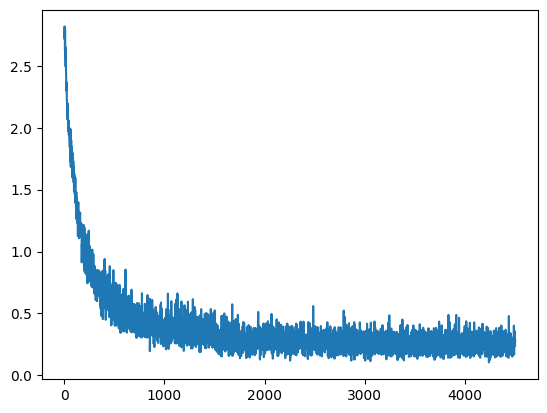

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
l_losses=len(losses)
print(l_losses)
x = np.arange(1,l_losses+1,1)
plot(x,losses)